In [ ]:
%load_ext autoreload
%autoreload 2

from text3d2video.artifacts.attn_features_artifact import AttentionFeaturesArtifact
from math import sqrt
from torch import Tensor
from omegaconf import OmegaConf

import text3d2video.wandb_util as wbu
import wandb

In [60]:
import torch
from diffusers import ControlNetModel, DPMSolverMultistepScheduler
from text3d2video.pipelines.controlnet_pipeline import ControlNetPipeline
from text3d2video.ipython_utils import display_ims

sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"

dtype = torch.float16
device = torch.device("cuda")

controlnet = ControlNetModel.from_pretrained(
    controlnet_repo, torch_dtype=torch.float16
).to(device)

pipe = ControlNetPipeline.from_pretrained(
    sd_repo, controlnet=controlnet, torch_dtype=dtype
).to(device)

pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [74]:
unet = pipe.unet
unet.down_blocks[0].attentions[0].transformer_blocks[0]

BasicTransformerBlock(
  (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
  (attn1): Attention(
    (to_q): Linear(in_features=320, out_features=320, bias=False)
    (to_k): Linear(in_features=320, out_features=320, bias=False)
    (to_v): Linear(in_features=320, out_features=320, bias=False)
    (to_out): ModuleList(
      (0): Linear(in_features=320, out_features=320, bias=True)
      (1): Dropout(p=0.0, inplace=False)
    )
  )
  (norm2): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
  (attn2): Attention(
    (to_q): Linear(in_features=320, out_features=320, bias=False)
    (to_k): Linear(in_features=768, out_features=320, bias=False)
    (to_v): Linear(in_features=768, out_features=320, bias=False)
    (to_out): ModuleList(
      (0): Linear(in_features=320, out_features=320, bias=True)
      (1): Dropout(p=0.0, inplace=False)
    )
  )
  (norm3): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
  (ff): FeedForward(
    (net): ModuleList(
      (0): GEGLU

In [33]:
api = wandb.Api()

attn_type = "0_attn"
attn_type = "self_attn"
attn_type = "extended_attn"

filters = {"tags": attn_type}
run = list(api.runs("romeu/diffusion-3D-features", filters=filters))[0]
conf = OmegaConf.create(run.config)
target_frame_indices = list(conf.cross_frame_attn_experiment.target_frame_indices)

attn_data = wbu.first_logged_artifact_of_type(
    run, AttentionFeaturesArtifact.wandb_artifact_type
)
attn_data = AttentionFeaturesArtifact.from_wandb_artifact(attn_data)

In [34]:
# read attn data
from text3d2video.attention_visualization import AttnFeatures, split_heads

multidict = attn_data.get_features_diskdict()
images = attn_data.get_images()
layer_names = sorted(multidict.key_values("layer"))
time_steps = sorted(multidict.key_values("timestep"))

dec_layers = [layer for layer in layer_names if "up_blocks" in layer]
enc_layers = [layer for layer in layer_names if "down_blocks" in layer]


def get_target_frame_indices(conf, frame_idx):
    attend_to_self = conf.cross_frame_attn_experiment.attend_to_self
    target_frame_indices = conf.cross_frame_attn_experiment.target_frame_indices.copy()
    if attend_to_self:
        target_frame_indices += [frame_idx]
    return target_frame_indices


def get_attn_features(layer, time_step):
    identifier = {"layer": layer, "timestep": time_step}

    # get queries keys and values
    qrys = multidict[identifier | {"name": "query"}][: len(images)]
    keys = multidict[identifier | {"name": "key"}][: len(images)]
    vals = multidict[identifier | {"name": "value"}][: len(images)]

    qrys_mh = split_heads(qrys)
    keys_mh = split_heads(keys)
    vals_mh = split_heads(vals)

    return AttnFeatures(qrys_mh, keys_mh, vals_mh, int(sqrt(qrys.shape[1])))

In [ ]:
from text3d2video.sd_feature_extraction import parse_layer_name

for l in dec_layers:
    parsed_layer = parse_layer_name(l)
    print(parsed_layer)

{'block_type': 'up_blocks', 'block_index': 1, 'attention_index': 0}
{'block_type': 'up_blocks', 'block_index': 1, 'attention_index': 1}
{'block_type': 'up_blocks', 'block_index': 1, 'attention_index': 2}
{'block_type': 'up_blocks', 'block_index': 2, 'attention_index': 0}
{'block_type': 'up_blocks', 'block_index': 2, 'attention_index': 1}
{'block_type': 'up_blocks', 'block_index': 2, 'attention_index': 2}
{'block_type': 'up_blocks', 'block_index': 3, 'attention_index': 0}
{'block_type': 'up_blocks', 'block_index': 3, 'attention_index': 1}
{'block_type': 'up_blocks', 'block_index': 3, 'attention_index': 2}


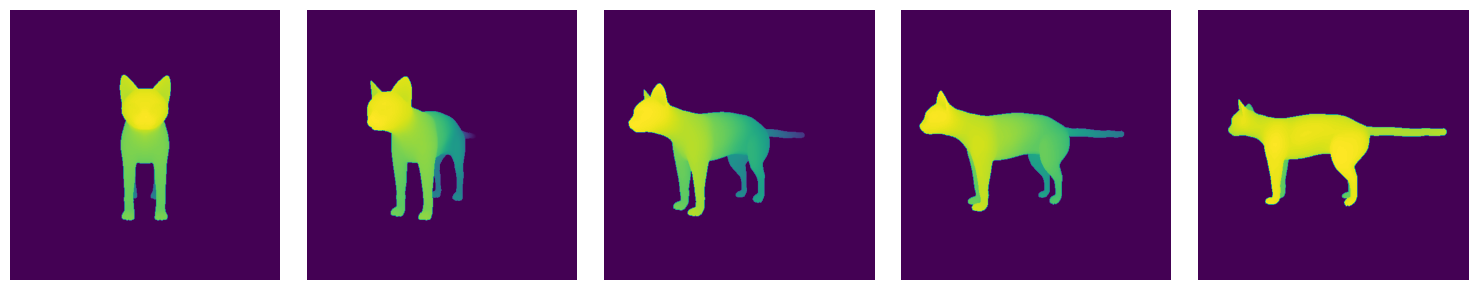

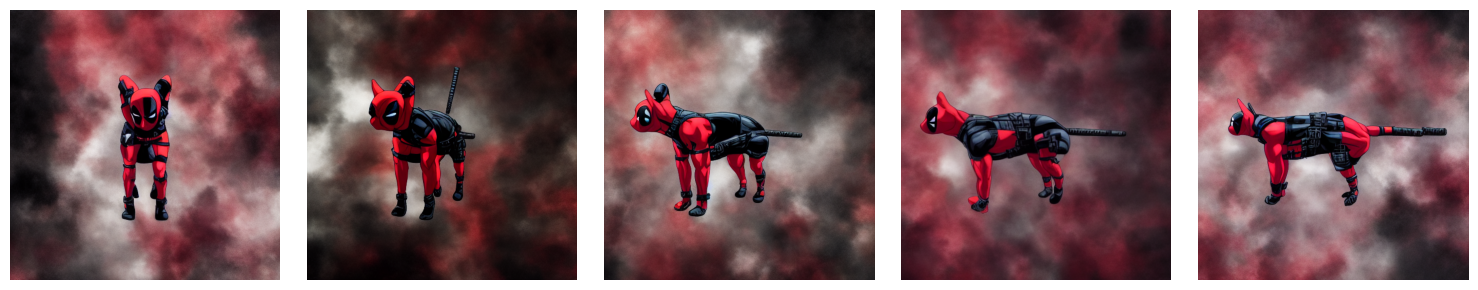

In [35]:
from text3d2video.artifacts.animation_artifact import AnimationArtifact
from text3d2video.ipython_utils import display_ims
from text3d2video.rendering import render_depth_map

animation = wbu.first_used_artifact_of_type(run, "animation")
animation = AnimationArtifact.from_wandb_artifact(animation)

n_frames = conf.animation.n_frames

frame_nums = animation.frame_nums(n_frames)
cameras = animation.cameras(frame_nums)
meshes = animation.load_frames(frame_nums)

depth_maps = render_depth_map(meshes, cameras)
display_ims(depth_maps, scale=3)
display_ims(images, scale=3)

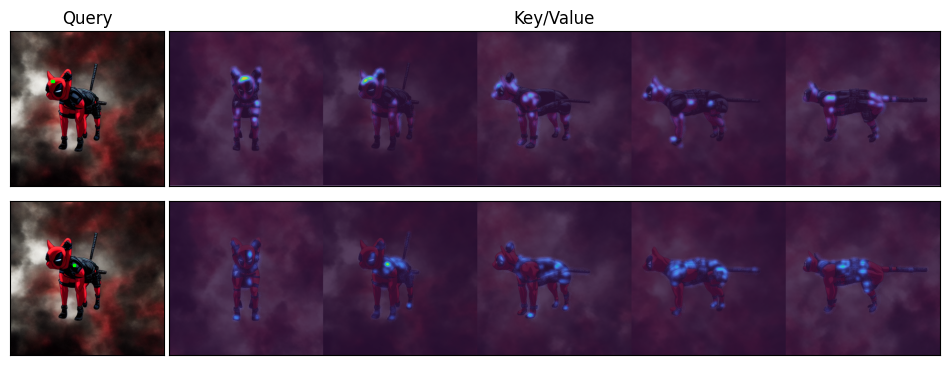

In [84]:
from text3d2video.attention_visualization import (
    get_attn_weights,
    make_gridspec_figure,
    plot_qry_weights,
)


def compare_qry_coords(
    layer, time_step, qry_coords=Tensor, frame_idx=0, head_idx=0, title=None
):
    target_frame_indices = get_target_frame_indices(conf, frame_idx)
    attn_features = get_attn_features(layer, time_step)
    attn_weights = get_attn_weights(attn_features, head_idx=head_idx)

    n_rows = len(qry_coords)
    height_ratios = [1] * n_rows
    width_ratios = [1, len(target_frame_indices)]

    fig, gs = make_gridspec_figure(n_rows, 2, width_ratios, height_ratios)

    for qry_idx in range(n_rows):
        ax_qry = fig.add_subplot(gs[qry_idx, 0])
        ax_val = fig.add_subplot(gs[qry_idx, 1])

        qry_coord = qry_coords[qry_idx]

        plot_qry_weights(
            ax_qry,
            ax_val,
            attn_features,
            attn_weights,
            qry_coord,
            frame_idx,
            target_frame_indices,
            images,
        )

        if qry_idx == 0:
            ax_qry.set_title("Query")
            ax_val.set_title("Key/Value")

        for ax in [ax_qry, ax_val]:
            ax.set_xticks([])
            ax.set_yticks([])


frame_idx = 1
head_idx = 3
time_step = time_steps[4]
coord_red = Tensor([0.28, 0.32])
coord_black = Tensor([0.41, 0.42])
layer = dec_layers[-1]

coords = [coord_red, coord_black]

compare_qry_coords(
    layer, time_step, coords, frame_idx=frame_idx, head_idx=head_idx, title="title"
)


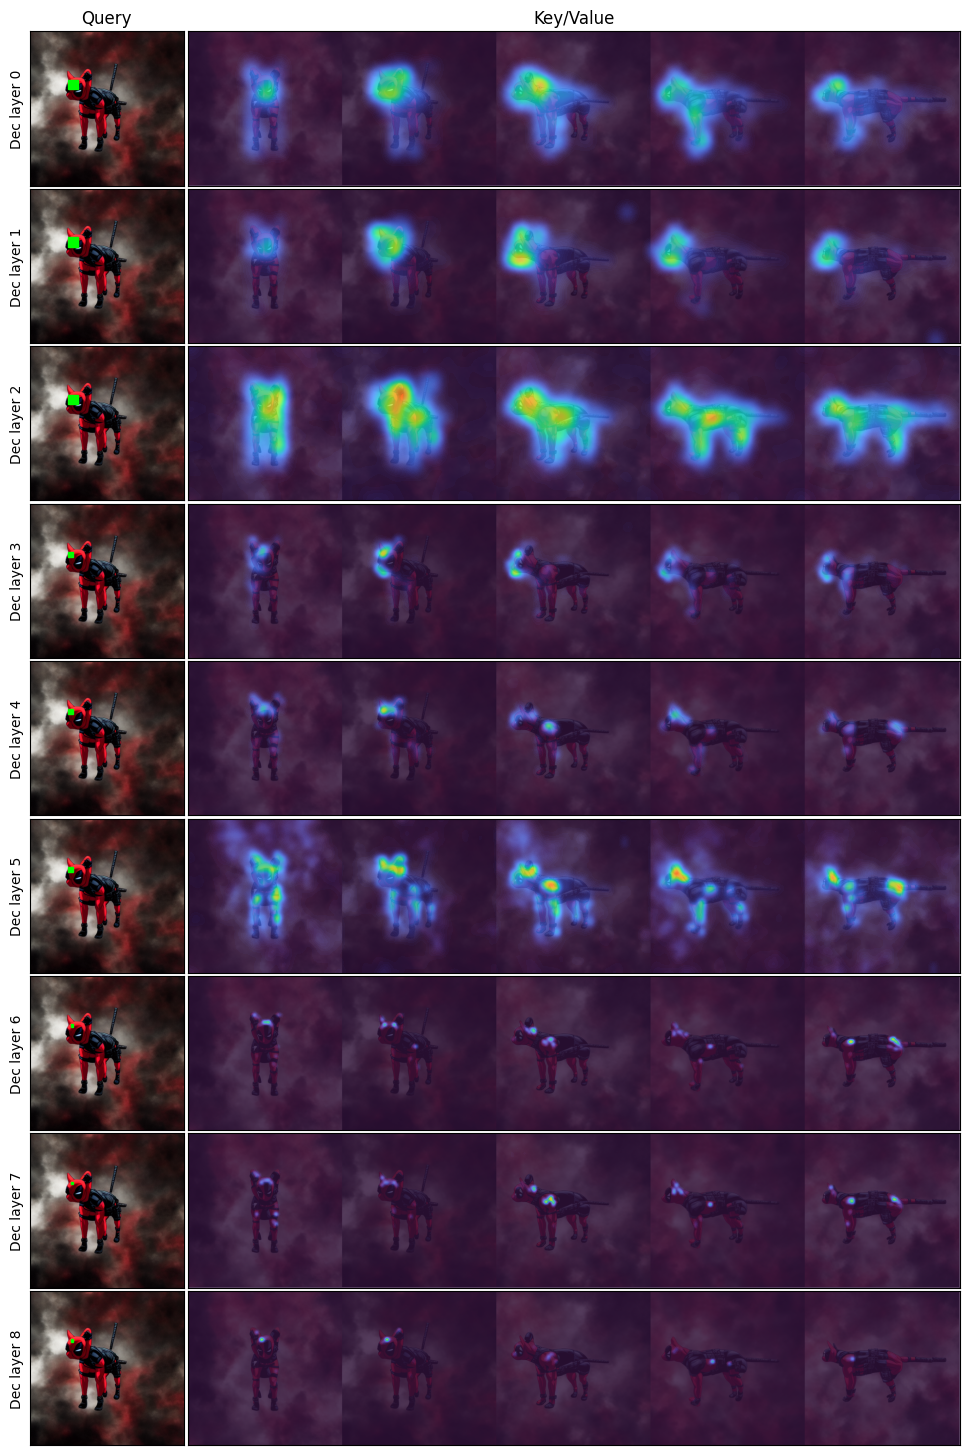

In [91]:
from typing import Callable, List

from text3d2video.sd_feature_extraction import flatten_layer_index, parse_layer_name


def compare_weights(
    layers: List[str],
    time_steps: List[str],
    qry_coords: List[Tensor],
    head_indices: List[int],
    frame_idx: int,
    label_fun: Callable = None
):
    assert (
        len(layers)
        == len(time_steps)
        == len(qry_coords)
        == len(head_indices)
    )

    target_frame_indices = get_target_frame_indices(conf, frame_idx)

    n_rows = len(layers)
    height_ratios = [1] * n_rows
    width_ratios = [1, len(target_frame_indices)]

    fig, gs = make_gridspec_figure(n_rows, 2, width_ratios, height_ratios)

    for i in range(n_rows):

        layer = layers[i]
        time_step = time_steps[i]
        qry_coord = qry_coords[i]
        head_idx = head_indices[i]
    
        attn_features = get_attn_features(layer, time_step)
        attn_weights = get_attn_weights(attn_features, head_idx=head_idx)

        ax_qry = fig.add_subplot(gs[i, 0])
        ax_val = fig.add_subplot(gs[i, 1])

        plot_qry_weights(
            ax_qry,
            ax_val,
            attn_features,
            attn_weights,
            qry_coord,
            frame_idx,
            target_frame_indices,
            images,
        )

        if i == 0:
            ax_qry.set_title("Query")
            ax_val.set_title("Key/Value")

        if label_fun:
            label = label_fun(layer, time_step, qry_coord, head_idx)
            ax_qry.set_ylabel(label)

        for ax in [ax_qry, ax_val]:
            ax.set_xticks([])
            ax.set_yticks([])

frame_idx = 1
head_idx = 0
time_step = time_steps[-1]
coord_red = Tensor([0.28, 0.32])
coord_black = Tensor([0.41, 0.42])
layer = dec_layers[-1]

fig_layers = dec_layers
n = len(fig_layers)

fig_coords = [coord_red] * n
fig_time_steps = [time_step] * n
fig_head_indices = [head_idx] * n

def label_fun(layer, time_step, coord, head_idx):
    layer_dict = parse_layer_name(layer)
    block_type = layer_dict["block_type"]
    flat_idx = flatten_layer_index(layer_dict)

    if block_type == "up_blocks":
        block_type_str = "Dec"
    elif block_type == "down_blocks":
        block_type_str = "Enc"
    elif block_type == "mid_block":
        block_type_str = "Mid"

    label = f"{block_type_str} layer {flat_idx}"

    return label

compare_weights(fig_layers, fig_time_steps, fig_coords, fig_head_indices, frame_idx, label_fun=label_fun)

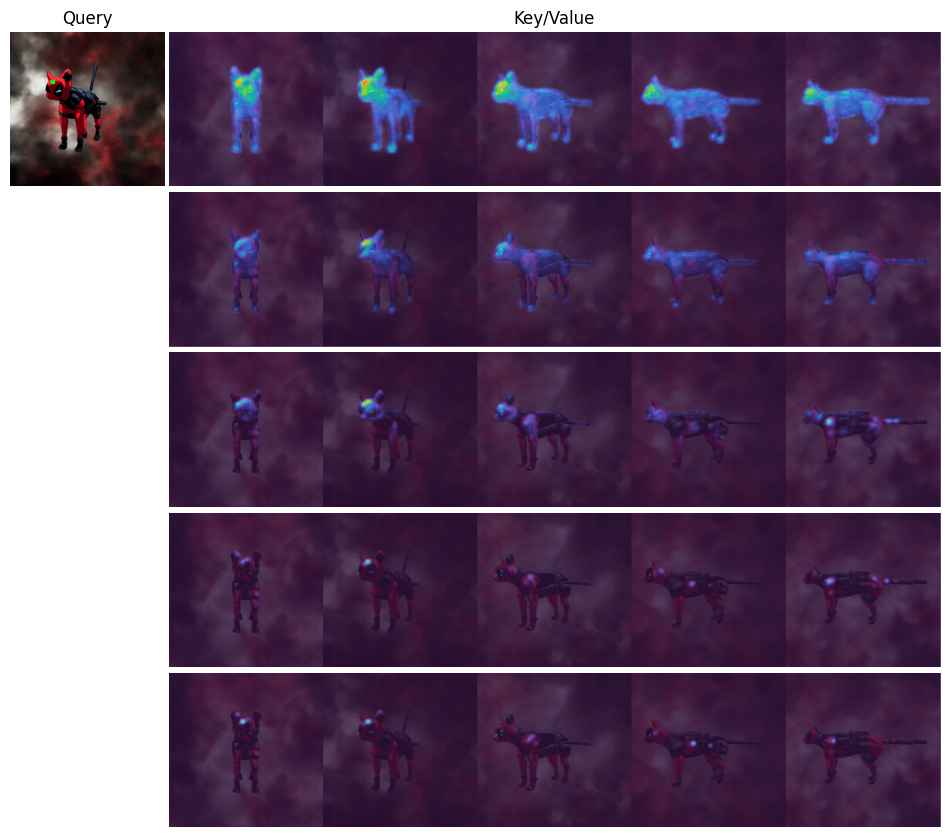

In [27]:
def compare_time_steps(
    layer, time_steps, qry_coord, frame_idx=0, head_idx=0, title=None
):
    target_frame_indices = get_target_frame_indices(conf, frame_idx)

    n_rows = len(time_steps)
    height_ratios = [1] * n_rows
    width_ratios = [1, len(target_frame_indices)]

    fig, gs = make_gridspec_figure(n_rows, 2, width_ratios, height_ratios)

    for i, t in enumerate(time_steps):
        # compute attn weights
        attn_features = get_attn_features(layer, t)
        attn_weights = get_attn_weights(attn_features, head_idx=head_idx)

        ax_val = fig.add_subplot(gs[i, 1])

        ax_val.axis("off")

        if i == 0:
            ax_qry = fig.add_subplot(gs[i, 0])
            ax_qry.set_title("Query")
            ax_val.set_title("Key/Value")
            ax_qry.axis("off")

        plot_qry_weights(
            ax_qry if i == 0 else None,
            ax_val,
            attn_features,
            attn_weights,
            qry_coord,
            frame_idx,
            target_frame_indices,
            images,
        )


coord_red = Tensor([0.28, 0.32])
coord_black = Tensor([0.41, 0.42])

frame_idx = 1
head_idx = 0
time_step = time_steps[4]
coord = coord_red
layer = dec_layers[-1]

compare_time_steps(
    layer, time_steps, coord, frame_idx=frame_idx, head_idx=head_idx, title="title"
)